In [1]:
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import Layer

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)





# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#     print('Device:', tpu.master())
# #     tf.config.experimental_connect_to_cluster(tpu)
# #     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)

# AUTOTUNE = tf.data.experimental.AUTOTUNE
    
# print(tf.__version__)

Number of replicas: 1
2.12.0


In [3]:
# EPOCHS = 100
# EPOCHS = 1
EPOCHS = 40
SIZE = 256
SIZE_RESIZE = 128
BATCH_SIZE = 16

In [4]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[SIZE_RESIZE, SIZE_RESIZE, 3])

    return cropped_image

def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) 
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) 
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1)
        
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    image = tf.image.random_crop(image, size=[SIZE_RESIZE, SIZE_RESIZE, 3])
        
    return image

IMAGE_SIZE = [SIZE, SIZE]

def decode_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.image.resize(image,[256, 256])
#     image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def load_dataset(path, apply_jitter=False, repeat=True, shuffle=True, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.list_files((path), shuffle=False)
    dataset = dataset.map(decode_image, num_parallel_calls=AUTOTUNE)
    
    if apply_jitter:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)
#         dataset = dataset.shuffle(512//2)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

### Figuring out data transfer to make the entire ting work :)

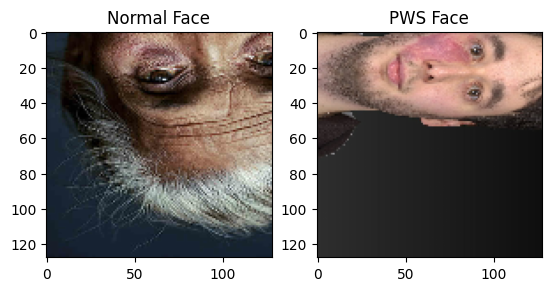

In [5]:
HUMAN_FACES_PATH = "/kaggle/input/human-faces/Humans/*.jpg"
PWS_FACES_PATH = "/kaggle/input/pws-cyclegan-pws-images/*.jpg"
human_ds = load_dataset(HUMAN_FACES_PATH, apply_jitter=True)
pws_ds = load_dataset(PWS_FACES_PATH, apply_jitter=True)

human_ds_test = load_dataset(HUMAN_FACES_PATH, apply_jitter=False, repeat=False, shuffle=False, batch_size=1)
pws_ds_test = load_dataset(PWS_FACES_PATH, apply_jitter=False, repeat=False, shuffle=False, batch_size=1)

example_human = next(iter(human_ds))
plt.subplot(121)
plt.title('Normal Face')
plt.imshow(example_human[0] * 0.5 + 0.5)

example_pws = next(iter(pws_ds))
plt.subplot(122)
plt.title('PWS Face')
plt.imshow(example_pws[0] * 0.5 + 0.5)

In [6]:
def count_data_items(path):
    filenames = tf.io.gfile.glob(path)
    return len(filenames)

n_pws_samples = count_data_items(PWS_FACES_PATH)
n_human_samples = count_data_items(HUMAN_FACES_PATH)

print(f"n_pws_samples:{n_pws_samples}")
print(f"n_human_samples:{n_human_samples}")

n_pws_samples:231
n_human_samples:6973


In [ ]:
def DiffAugment(x, policy='', channels_first=False):
    if policy:
        if channels_first:
            x = tf.transpose(x, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if channels_first:
            x = tf.transpose(x, [0, 3, 1, 2])
    return x


def rand_brightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    x = x + magnitude
    return x


def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x


def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
    x = x * tf.expand_dims(mask, axis=3)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

def aug_fn(image):
    return DiffAugment(image,"translation,cutout")

# Designing Model's architecture
### ResNet Generator

In [ ]:
def Downsample(X, filter_count, kernel_size, padding, stride, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X = tf.keras.layers.ZeroPadding2D((padding,padding))(X)
    X = tf.keras.layers.Conv2D(filter_count, (kernel_size,kernel_size), padding='valid', strides=(stride,stride), 
                                      kernel_initializer=initializer, use_bias=False)(X)
    
    if apply_norm:
        X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    
    X = tf.keras.layers.LeakyReLU()(X)
    
    return X

def Upsample(X, filter_count, kernel_size, stride, activation='relu', apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    X = tf.keras.layers.Conv2DTranspose(filter_count, (kernel_size,kernel_size), padding='same', strides=(stride,stride), 
                                        kernel_initializer=initializer, use_bias=False)(X)
    
    if apply_norm:
        X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
        
    X = tf.keras.layers.Activation(activation)(X)
    
    return X

def ResidualBlock(X):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X_shortcut = X
    
    # Layer 1   
    X = tf.keras.layers.ZeroPadding2D((1,1))(X)
    X = tf.keras.layers.Conv2D(256, (3,3), padding='valid', strides=(1,1), kernel_initializer=initializer, use_bias=False)(X)
    X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # Layer 2  
    X = tf.keras.layers.ZeroPadding2D((1,1))(X)
    X = tf.keras.layers.Conv2D(256, (3,3), padding='valid', strides=(1,1), kernel_initializer=initializer, use_bias=False)(X)
    X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

def ResNetGenerator(height=SIZE, width=SIZE):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X_input = tf.keras.layers.Input((height, width, 3))
    
    skips = []
    
    X = Downsample(X_input, 64, 7, 3, 1, apply_norm=False)
    skips.append(X)
    
    X = Downsample(X, 128, 3, 1, 2)
    skips.append(X)
    
    X = Downsample(X, 256, 3, 1, 2)
    
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    #X = ResidualBlock(X)
    #X = ResidualBlock(X)
    #X = ResidualBlock(X)
    
    skips = list(reversed(skips))
        
    X = Upsample(X, 128, 4, 2)
    X = tf.keras.layers.Concatenate()([X, skips[0]])
    
    X = Upsample(X, 64, 4, 2)
    X = tf.keras.layers.Concatenate()([X, skips[1]])
    
    X = Upsample(X, 3, 7, 1, activation='tanh', apply_norm=False)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)

    return model

# generator = ResNetGenerator()
# generator.summary()

### PatchGAN Discriminator

In [ ]:
def Discriminator(height=SIZE, width=SIZE):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X_input = tf.keras.layers.Input((height, width, 3))

    X = Downsample(X_input, 64, 4, 1, 2, apply_norm=False)
    X = Downsample(X, 128, 4, 1, 2)
    X = Downsample(X, 256, 4, 1, 2)
    X = Downsample(X, 512, 4, 1, 1)
    
    X = tf.keras.layers.ZeroPadding2D()(X)
    X = tf.keras.layers.Conv2D(1, (4,4), padding='valid', strides=(1,1), kernel_initializer=initializer, use_bias=False)(X)   
    X = tf.keras.layers.Activation('sigmoid')(X)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)

    return model

# discriminator = Discriminator()
# discriminator.summary()

In [ ]:
with strategy.scope():
    monet_generator = ResNetGenerator(height=None, width=None) # transforms photos to Monet-esque paintings
    photo_generator = ResNetGenerator(height=None, width=None) # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator(height=None, width=None) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator(height=None, width=None) # differentiates real photos and generated photos

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Diff Augmentation Start
            both_monet = tf.concat([real_monet, fake_monet], axis=0)      
            both_photo = tf.concat([real_photo, fake_photo], axis=0)            
            
            aug_monet = aug_fn(both_monet)
            aug_photo = aug_fn(both_photo)
            
            aug_real_monet, aug_fake_monet = tf.split(aug_monet, num_or_size_splits=2, axis=0)
            aug_real_photo, aug_fake_photo = tf.split(aug_photo, num_or_size_splits=2, axis=0)
            # Diff Augmentation End
            
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(aug_real_monet, training=True)
            disc_real_photo = self.p_disc(aug_real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(aug_fake_monet, training=True)
            disc_fake_photo = self.p_disc(aug_fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [ ]:
@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.
    
    steps_per_epoch = int(max(n_pws_samples, n_human_samples)//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8
    
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

In [ ]:
with strategy.scope():
        
    
#     lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
#     lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    
#     lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
#     lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))
    
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    

# Training

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
history = cycle_gan_model.fit(tf.data.Dataset.zip((pws_ds, human_ds)), 
                        epochs=EPOCHS, 
                        steps_per_epoch=max(n_pws_samples, n_human_samples)//BATCH_SIZE).history

In [ ]:
loss_results_df = pd.DataFrame(history)
loss_results_df = loss_results_df.applymap(np.mean)


plt.plot(loss_results_df.index, loss_results_df['monet_gen_loss'], color='g', label='Loss Monet Generator')
plt.plot(loss_results_df.index, loss_results_df['photo_gen_loss'], color='r', label='Loss Photo Generator')
plt.plot(loss_results_df.index, loss_results_df['monet_disc_loss'], color='b', label='Loss Monet Discriminator')
plt.plot(loss_results_df.index, loss_results_df['photo_disc_loss'], color='m', label='Loss Photo Discriminator')
plt.legend(loc='best')
plt.show()

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(human_ds_test.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo (normal face)")
    ax[i, 1].set_title("Face w. PWS")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(pws_ds_test.take(5)):
    prediction = photo_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Face w. PWS")
    ax[i, 1].set_title("Input Photo (normal face)")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Save results

In [ ]:
MODEL_DICT = {
    "monet_generator" : monet_generator,
    "photo_generator" : photo_generator,
    "monet_discriminator" : monet_discriminator,
     "photo_discriminator" : photo_discriminator
}

for name, model in MODEL_DICT.items():
    model.save(f"{name}.h5")

In [ ]:
import PIL
try: 
    ! mkdir ../images 
except: pass
try: 
    ! mkdir ../images/human-into-pws/ 
except: pass
try: 
    ! mkdir ../images/pws-into-human/ 
except: pass
try: 
    ! mkdir /images 
except: pass
try: 
    ! mkdir /images/human-into-pws/ 
except: pass
try: 
    ! mkdir /images/pws-into-human/ 
except: pass


i = 1
for img in human_ds_test:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/human-into-pws/" + str(i) + ".jpg")
    i += 1
    if i==1000:
        break
    
for img in pws_ds_test:
    prediction = photo_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/pws-into-human/" + str(i) + ".jpg")
    print(f"i: {i}")
    i += 1
    
    
    
import shutil
shutil.make_archive("/kaggle/working/images/human-into-pws/", 'zip', "/kaggle/images")
shutil.make_archive("/kaggle/working/images/pws-into-human/", 'zip', "/kaggle/images")